In [5]:
import re
import sys
from collections import Counter, defaultdict

import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.stats.api as sms
from IPython.display import Audio
from matplotlib import pyplot as plt
from mlxtend.classifier import EnsembleVoteClassifier, StackingClassifier
from pylab import cm
from scipy.stats import ttest_ind
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    multilabel_confusion_matrix,
    plot_confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelBinarizer,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [6]:
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/john/.conda/envs/pubmed/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [7]:
# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
print(font_names)
# Edit the font, font size, and axes width
mpl.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.linewidth"] = 2
# Generate 2 colors from the 'tab10' colormap
colors = cm.get_cmap("tab10", 2)

sound_file = "https://www.soundjay.com/buttons/button-09a.wav"  # https://www.soundjay.com/buttons/sounds/button-1.mp3
alarm = Audio(sound_file, autoplay=True)

['cmb10', 'STIXSizeFourSym', 'cmr10', 'DejaVu Serif Display', 'STIXGeneral', 'STIXGeneral', 'STIXSizeTwoSym', 'cmmi10', 'DejaVu Serif', 'STIXNonUnicode', 'DejaVu Sans Mono', 'DejaVu Sans', 'cmex10', 'DejaVu Serif', 'STIXGeneral', 'DejaVu Sans', 'STIXSizeFourSym', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'cmsy10', 'cmtt10', 'STIXSizeOneSym', 'DejaVu Sans Display', 'STIXNonUnicode', 'STIXGeneral', 'cmss10', 'STIXNonUnicode', 'STIXSizeThreeSym', 'DejaVu Sans', 'STIXSizeThreeSym', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXSizeOneSym', 'STIXNonUnicode', 'STIXSizeFiveSym', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans']


# loading data

In [8]:
silo1 = pd.read_csv(
    "/mnt/c/Users/joaof/Desktop/tese_local/chvng/CHVNGE_OBSCARE_WCR.csv", sep=";"
)

In [9]:
silo2 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/CHEDV/CHEDV_OBSCARE_WCR_.xlsx",
    engine="openpyxl",
)

In [10]:
silo3 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/CHBV/CHBV_OBSCARE_WCR.xlsx",
    engine="openpyxl",
)

silo4 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/CHLN/CHLN_OBSCARE_WCR.xlsx",
    engine="openpyxl",
)

silo5 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/CHSJ/CHSJ_OBSCARE_WCR.xlsx",
    engine="openpyxl",
)

silo6 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/HSO/HSO_OBSCARE_WCR.xlsx",
    engine="openpyxl",
)

silo7 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/ULSAM/ULSAM_OBSCARE_WCR.xls"
)

silo8 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/ULSM/ULSM_OBSCARE_WCR_V1.xlsx",
    engine="openpyxl",
)

silo9 = pd.read_excel(
    "/mnt/c/Users/joaof/Desktop/tese_local/Obscare Giovana/CHTS/CHTS_OBSCARE_WCR_.xlsx",
    engine="openpyxl",
)

WARNING *** file size (5079264) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


## Preparing data

In [11]:
silos = []
for i in range(9):
    silos.append(eval("silo" + str(i + 1)))

In [12]:
# based on https://github.com/datafleets/horizontal-federated-learning-blog/blob/master/horizontal-fl.ipynb

In [13]:
def preprocessing_df(
    df,
    categorical_columns,
    integ_colums,
    drop_cols=["G_TERAPEUTICA", "IDENTIFICADOR"],
    pipeline=["imputer", "encoder"],
):
    if len(df.columns) != len(categorical_columns) + len(integ_colums) + len(drop_cols):
        # raise Exception
        print("WARNING! Columns number different")
    df1 = df.copy()

    def simple_imputer_categorical_df(df, columns):
        imputer = SimpleImputer(
            missing_values=np.nan, strategy="constant", fill_value="NULLIMP"
        )  # está a por NULL em variaveis com nrs(apesar de considerar cat)
        imputer.fit(df[columns])
        X = pd.DataFrame(imputer.transform(df[columns]))
        return X

    def simple_imputer_numeric_df(df, columns):
        imputer = SimpleImputer(missing_values=np.nan, strategy="median")
        imputer.fit(df[columns])
        X = pd.DataFrame(imputer.transform(df[columns]))
        return X

    def scikit_one_hot_encoder(df, categorical_columns):
        enc_hot = OneHotEncoder(handle_unknown="ignore", sparse=False)
        enc_hot.fit(df[categorical_columns].astype(str))
        X = pd.DataFrame(
            enc_hot.transform(df[categorical_columns].astype(str)),
            columns=enc_hot.get_feature_names(df[categorical_columns].columns),
        )
        data_encoded = pd.concat([df, X], axis=1)
        data_encoded.drop(columns=df[categorical_columns].columns, inplace=True)
        return data_encoded

    df1.drop(columns=drop_cols, inplace=True)
    if "imputer" in pipeline:
        df1[categorical_columns] = simple_imputer_categorical_df(
            df1, categorical_columns
        )
        df1[integ_colums] = simple_imputer_numeric_df(df1, integ_colums)

    if "encoder" in pipeline:
        df1 = scikit_one_hot_encoder(df1, categorical_columns)

    return df1

In [14]:
def create_target(y, op="encoder"):
    if op == "binarizer":
        l = LabelBinarizer()
        #    print(y_pipe.fit_transform(y))
        yy = l.fit_transform(y)
    elif op == "encoder":
        # label
        l = LabelEncoder()
        yy = l.fit_transform(y.astype(str))
    else:
        raise ("unkown op")
    return yy, l


def create_pipeline_with_y(
    data,
    target,
    int_cols,
    cat_cols,
    drop_cols=None,
    pipeline=None,
    op="encoder",
    as_df=False,
):
    _cat_cols = [colc for colc in cat_cols if colc not in [target]]
    _int_cols = [coli for coli in int_cols if coli not in [target]]
    n_df = data.copy().drop(columns=drop_cols + [target])

    def to_object(x):
        return pd.DataFrame(x).astype(str)

    if pipeline == None:
        fun_tr = FunctionTransformer(to_object)

        numeric_transformer = Pipeline(
            steps=[
                ("imputer1", SimpleImputer(strategy="median", missing_values=np.nan)),
                ("imputer2", SimpleImputer(strategy="median", missing_values=-1)),
            ]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("fun_tr", fun_tr),
                (
                    "imputer",
                    SimpleImputer(
                        missing_values=np.nan, strategy="constant", fill_value="NULLIMP"
                    ),
                ),
                ("ordinalEncoder", OrdinalEncoder()),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, _int_cols),
                ("cat", categorical_transformer, _cat_cols),
            ]
        )

        pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

        y = data[target]
        X = n_df
        y_pipe = make_pipeline(
            SimpleImputer(
                missing_values=np.nan, strategy="constant", fill_value="NULLIMP"
            )
        )
        yy, l = create_target(y, op=op)
        XX = pipeline.fit_transform(X)

        if as_df == True:
            col_list = (
                pipeline["preprocessor"].transformers_[0][2]
                + pipeline["preprocessor"].transformers_[1][2]
            )
            print(len(col_list))
            df1 = pd.DataFrame(XX, columns=col_list)
            r = pd.concat([df1, pd.DataFrame(yy)], axis=1)
            r.rename(columns={0: target}, inplace=True)
            return r, _, pipeline, l
        return XX, yy, pipeline, l

In [15]:
int_cols = [
    "IDADE_MATERNA",
    "PESO_INICIAL",
    "IMC",
    "NUMERO_CONSULTAS_PRE_NATAL",
    "IDADE_GESTACIONAL_ADMISSAO",
    "SEMANAS_GESTACAO_PARTO",
    "PESO_ADMISSAO_INTERNAMENTO",
]

In [16]:
drop_cols = [
    "IDENTIFICADOR",
    "G_TERAPEUTICA",
    "DATA_PARTO",
    "CESARIANAS_MOTIVO_ANTERIOR",
    "NUM_RN",
    "ESTIMATIVA_PESO_ECO_24",
    "ESTIMATIVA_PESO_ECO_25",
    "ESTIMATIVA_PESO_ECO_26",
    "ESTIMATIVA_PESO_ECO_27",
    "ESTIMATIVA_PESO_ECO_28",
    "ESTIMATIVA_PESO_ECO_29",
    "ESTIMATIVA_PESO_ECO_30",
    "ESTIMATIVA_PESO_ECO_31",
    "ESTIMATIVA_PESO_ECO_32",
    "ESTIMATIVA_PESO_ECO_33",
    "ESTIMATIVA_PESO_ECO_34",
    "ESTIMATIVA_PESO_ECO_35",
    "ESTIMATIVA_PESO_ECO_36",
    "ESTIMATIVA_PESO_ECO_37",
    "ESTIMATIVA_PESO_ECO_38",
    "ESTIMATIVA_PESO_ECO_39",
    "ESTIMATIVA_PESO_ECO_40",
    "ESTIMATIVA_PESO_ECO_41",
    "ESTIMATIVA_PESO_ECO_42",
    "APRESENTACAO_24",
    "APRESENTACAO_25",
    "APRESENTACAO_26",
    "APRESENTACAO_27",
    "APRESENTACAO_28",
    "APRESENTACAO_29",
    "APRESENTACAO_30",
    "APRESENTACAO_31",
    "APRESENTACAO_32",
    "APRESENTACAO_33",
    "APRESENTACAO_34",
    "APRESENTACAO_35",
    "APRESENTACAO_36",
    "APRESENTACAO_37",
    "APRESENTACAO_38",
    "APRESENTACAO_39",
    "APRESENTACAO_40",
    "APRESENTACAO_41",
    "APRESENTACAO_42",
]

In [17]:
cat_cols = list(set(silos[0].columns) - set(drop_cols) - set(int_cols))

In [18]:
silos[0].columns[silos[0].isna().all()].tolist()

['CESARIANAS_MOTIVO_ANTERIOR',
 'ESTIMATIVA_PESO_ECO_41',
 'ESTIMATIVA_PESO_ECO_42',
 'APRESENTACAO_42',
 'APRESENTACAO_41',
 'E_ALT_UT']

In [19]:
silosprep = []
silo_imputed = []
silos_stats = []
for silo in silos:
    silos_stats.append(silo.copy())
    silosprep.append(
        preprocessing_df(
            silo,
            categorical_columns=cat_cols,
            integ_colums=int_cols,
            drop_cols=drop_cols,
        )
    )
    silo_imputed.append(
        create_pipeline_with_y(
            silo.copy(),
            "GRUPO_ROBSON",
            int_cols=int_cols,
            cat_cols=cat_cols,
            as_df=True,
            drop_cols=drop_cols,
        )[0]
    )

52
52
52
52
52
52
52
52
52


In [20]:
resulting_list = []
for silo in silosprep:
    resulting_list.extend(x for x in silo.columns.tolist() if x not in resulting_list)
for col in resulting_list:
    for i in range(len(silosprep)):
        if col not in silosprep[i].columns:
            silosprep[i][col] = 0

In [21]:
c = Counter()
final_list = []
for s in silos_stats:
    c.update(s.columns)
for col in c.keys():
    if c[col] == 9:
        final_list.append(col)

In [22]:
for col in final_list:
    for i in range(len(silos_stats)):
        #  print(silos_stats[i].columns)
        if col not in silos_stats[i].columns:
            silos_stats[i][col] = np.nan

In [20]:
for silo in silos_stats:
    print(len(silo.columns))

96
96
96
96
96
96
96
96
96


In [23]:
def get_summary(silo, col, type_col):
    if type_col == "categorical":
        if silo[col].isna().sum() == len(silo):
            return str("Null [100%]")
        mode = silo[col].mode()
        freq = silo[col].value_counts()[mode].values[0]
        perc = freq / len(silo[col])
        if len(str(mode.values[0])) > 6:
            # return str(mode.values[0])[0:5].lower() +" .. "+str(mode.values[0])[-3:].lower()+ " [" + str(round(perc * 100, 1)) + "%]"
            return (
                str(mode.values[0])[0:5].lower()
                + ".. ["
                + str(round(perc * 100, 0))
                + "%]"
            )

        else:
            return str(mode.values[0]).lower() + " [" + str(round(perc * 100, 0)) + "%]"
    # return " [" + str(round(perc * 100, 1)) + "%]"

    if type_col == "continuous":
        mean = silo[col].mean()
        std = silo[col].std()
        return str(round(mean, 1)) + " (" + str(round(std, 1)) + ")"


def create_analysis_silos(silos, cat_cols, int_cols, drop_cols):

    result = {}
    for idx, silo in enumerate(silos):
        silo = silo.copy().drop(columns=drop_cols)
        col_list = silo.columns
        result["silo" + str(idx + 1)] = []
        for col in silo.columns:
            #  print(col)
            type_col = "categorical" if col in cat_cols else "continuous"
            result["silo" + str(idx + 1)].append(get_summary(silo, col, type_col))
    return result, col_list


df_dict, col = create_analysis_silos(silos_stats, cat_cols, int_cols, drop_cols)

In [24]:
def create_multirow_latex(cell):
    n_c = cell.replace("_", " ").lower()
    if len(cell) > 20:
        return (
            "\\begin{tabular}{@{}l@{}}"
            + n_c[0:10]
            + "\\\\"
            + n_c[10:]
            + "\\end{tabular}"
        )
    else:
        return n_c

In [31]:
summ_stats = pd.DataFrame.from_dict(df_dict, orient="columns")

In [33]:
summ_stats = pd.concat([pd.DataFrame(col), summ_stats], axis=1)
summ_stats.rename(columns={0: "column"}, inplace=True)

In [36]:
summ_stats["column"]=summ_stats["column"].apply(create_multirow_latex)

In [38]:
f = open("teste_html.html", "w")
f.write(summ_stats.to_html())
f.close()

In [39]:
f = open("teste_latex.tex", "w")
f.write(
    summ_stats.to_latex(
        index=False,
        multirow=True,
        escape=True,
        caption="Summary statistics of the silos",
        longtable=True,
        column_format="|l|l|l|l|l|l|l|l|l|l|",
    )
    .replace("\\textbackslash ", "\\")
    .replace("\\}", "}")
    .replace("\\{", "{")
)
f.close()

In [40]:
with open("my_table.tex", "w") as f:
    f.write("\\begin{longtable}{|" + "|".join(["l"] * len(summ_stats.columns)) + "|}\n")
    f.write(
        """\\caption{Summary statistics of the silos}\\\\
\\toprule
Column & silo1 & silo2 & silo3 & silo4 & silo5 & silo6 & silo7 & silo8 & silo9 \\\\
\\midrule
\\endhead
\\midrule
\\multicolumn{10}{r}{{Continued on next page}} \\\\
\\midrule
\\endfoot
\\bottomrule
\\endlastfoot """
    )
    for i, row in summ_stats.iterrows():
        f.write(
            " & ".join([str(x).replace("%", "\%") for x in row.values])
            + " \\\\\hline\n"
        )
    f.write("\\end{longtable}")

## Modelling

In [41]:
class myvotingClassifier:  # estimators,X,voting="soft",weigths=None,limit=0.5
    def __init__(self, estimators, voting="soft", weights=None, threshold=0.5):
        self.estimators = estimators
        self.voting = voting
        self.weights = weights
        self.threshold = threshold

    def set_weigths(self, w):
        self.weights = w

    def __repr__(self):
        return "myvotingClassifier(voting='" + self.voting + "')"

    def __str__(self):
        return "instance of myvotingClassifier"

    def get_weigths(self):
        return self.w

    def f(self, x):
        return 1 if x >= self.threshold else 0

    def array_for(self, x):
        return np.array([self.f(xi) for xi in x])

    def predict(self, X):
        preds = np.zeros((len(self.estimators), len(X)))
        for idx, est in enumerate(self.estimators):
            if self.voting == "soft":
                preds[idx, :] = est.predict_proba(X)[:, 1]
            else:  # hard
                preds[idx, :] = est.predict(X)[:, 1]

        avg = np.average(preds, axis=0, weights=self.weights)

        result = self.array_for(avg)
        return result

    def predict_proba(self, X):
        preds = np.zeros((len(self.estimators), len(X)))
        avg = np.average(preds, axis=0, weights=self.weights)
        return avg

    def tune_estimator_weights(
        self, X_train_list, y_train_list, scoring="accuracy", n_repeats=10
    ):
        result = []
        i = 0
        for idx in range(len(X_train_list)):
            for clf in self.estimators:
                yy, l = create_target(y_train_list[idx], op="binarizer")
                scores = accuracy_score(
                    clf.predict(X_train_list[idx]), y_train_list[idx]
                )
                result.append(scores)
                i += scores
        self.w = [v / i for v in result]

    def set_threshold(self, threshold):
        self.threshold = threshold

In [42]:
def create_global_model(models, method, w=None):
    if method == "average":
        r_intercepts = []
        r_coefs = []
        r_weights = []
        unique_classes = models[0].classes_
        for l_model in models:
            r_intercepts.append(l_model.intercept_)
            r_coefs.append(l_model.coef_)
            r_weights.append(1 / len(models))
        g_coef_ = np.zeros((1, len(silo1prep.columns)))

        for _ in range(len(models)):
            g_intercept_ = np.average(r_intercepts, axis=0, weights=r_weights)
            g_coef_ = np.average(r_coefs, axis=0, weights=r_weights)
            global_model = set_weights(g_intercept_, g_coef_, unique_classes)
    elif method == "voting":
        global_model = myvotingClassifier(models, weights=w)
        lr = LogisticRegression()
        eclf = EnsembleVoteClassifier(clfs=models, weights=w, fit_base_estimators=False)
        sclf = StackingClassifier(
            classifiers=models,
            meta_classifier=lr,
            fit_base_estimators=False,
            use_probas=True,
            average_probas=False,
        )
    else:  # partial fit
        global_model = None
    return {"myvoting": global_model, "ensemble": eclf, "stacking": sclf}

In [44]:
def get_best_threshold(model, X_list, y_list):
    best = 0
    b_threshold = 0.5
    for threshold in np.arange(0, 1, 0.01):
        avg_list = []
        for X, y in zip(X_list, y_list):
            try:
                avg_list.append(roc_auc_score(model.predict(X, threshold), y))
            except:
                avg_list.append(np.nan)
        avg = np.mean(avg_list)
        if avg > best:
            best = avg
            b_threshold = threshold
    return b_threshold, best

In [43]:
def define_weights(grid_list):
    i = 0
    result_list = []
    for grid in grid_list:
        result_list.append(grid.best_score_)
        i += grid.best_score_
    return [v / i for v in result_list]

In [45]:
def prepare_global_model_init(g_model, X_train, y_train, model_type):
    threshold = get_best_threshold(g_model["myvoting"], X_train, y_train)
    g_model["myvoting"].set_threshold(threshold[0])
    g_model["ensemble"].fit(X_train, y_train)
    g_model["stacking"].fit(X_train, y_train)
    return g_model

In [46]:
def evaluate_federated_model(
    silos, target, metrics, cv, tuned_parameters, model, model_type="myvoting"
):
    """
    for every silo, trains and local model with hyperparameter tuning (CV)
    After that, creates a global_model and with all locals and global evaluates on the test set several metrics
    
    """
    grid_list = []
    result = {}
    models = []
    test_sets = []
    X_train_list = []
    y_train_list = []
    for idx, silo in enumerate(silos):
        if "random_state" in model.get_params().keys():
            model.set_params(random_state=np.random.randint(1, 20))
        #  print(model.get_params())
        clf = GridSearchCV(
            model, tuned_parameters, cv=StratifiedKFold(n_splits=cv), n_jobs=-2
        )

        y = silo[target]
        X = silo.drop(columns=[target])
        if len(y.unique()) > 2:
            yy, l = create_target(y, op="binarizer")
            X_train, X_test, y_train, y_test = train_test_split(
                X, yy[:, 0], test_size=0.2, stratify=yy[:, 0]
            )

        else:
            #    print("target has "+str(len(y.unique()))+" unique values")
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y
            )
        test_sets.append((y_test, X_test))
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        models.append(clf.fit(X_train, y_train).best_estimator_)
        grid_list.append(clf)

    w = define_weights(grid_list)
    global_model = create_global_model(models, "voting", w)
    global_model = prepare_global_model_init(
        global_model, X_train_list[0], y_train_list[0], model_type
    )

    for idx, tests in enumerate(test_sets):
        y_pred_l = models[idx].predict(tests[1])
        y_pred_g = global_model[model_type].predict(tests[1])
        for metric in metrics:
            if metric == "accuracy":
                result["silo" + str(idx + 1) + "_accuracy_local"] = accuracy_score(
                    y_pred_l, tests[0]
                )
                result["silo" + str(idx + 1) + "_accuracy_global"] = accuracy_score(
                    y_pred_g, tests[0]
                )
            if metric == "roc_auc_score":
                try:
                    result[
                        "silo" + str(idx + 1) + "_roc_auc_score_local"
                    ] = roc_auc_score(y_pred_l, tests[0])

                except:
                    result["silo" + str(idx + 1) + "_roc_auc_score_local"] = np.nan
                try:
                    result[
                        "silo" + str(idx + 1) + "_roc_auc_score_global"
                    ] = roc_auc_score(y_pred_g, tests[0])

                except:
                    result["silo" + str(idx + 1) + "_roc_auc_score_global"] = np.nan
            if metric == "f1":
                result["silo" + str(idx + 1) + "_f1_local"] = f1_score(
                    y_pred_l, tests[0]
                )
                result["silo" + str(idx + 1) + "_f1_global"] = f1_score(
                    y_pred_g, tests[0]
                )

    g_model = global_model

    return result, models, g_model

In [47]:
def evalute_full_method(
    targets,
    silos,
    metrics,
    tuned_parameters,
    cv,
    model=SGDClassifier(loss="log"),
    repeats=2,
    model_type="myvoting",
):
    total = {k: [] for k in targets}
    np.random.seed(42)
    for target in targets:
        print("evaluating " + target + "... ")
        total[target] = {}
        total[target]["models"] = []
        total[target]["g_model"] = []
        for metric in metrics:
            for silonr, silo in enumerate(silos):
                total[target]["silo" + str(silonr + 1) + "_" + metric + "_local"] = []
                total[target]["silo" + str(silonr + 1) + "_" + metric + "_global"] = []
        for i in range(repeats):
            t = evaluate_federated_model(
                silos=silos,
                target=target,
                metrics=metrics,
                tuned_parameters=tuned_parameters,
                cv=cv,
                model=model,
                model_type=model_type,
            )
            for metric in metrics:
                for silonr, silo in enumerate(silos):
                    total[target][
                        "silo" + str(silonr + 1) + "_" + metric + "_local"
                    ].append(t[0]["silo" + str(silonr + 1) + "_" + metric + "_local"])

                    total[target][
                        "silo" + str(silonr + 1) + "_" + metric + "_global"
                    ].append(t[0]["silo" + str(silonr + 1) + "_" + metric + "_global"])
            total[target]["models"].append(t[1])
            total[target]["g_model"].append(t[2])
    return total

In [62]:
def get_stats(total, print_val=False,):
    final = {}
    total_values = []
    for k, v in total.items():
        for p, t in v.items():
            if p not in ["models", "g_model"]:
                mean = np.nanmean(t)
                median = np.median(t)
                #   ci = sms.DescrStatsW(t).tconfint_mean()
                ci = st.t.interval(
                    alpha=0.95,
                    df=len(t) - 1,
                    loc=np.nanmean(t),
                    scale=st.sem(t, nan_policy="omit"),
                )
                if print_val:
                    print(k, p, mean, median, ci)
                data = np.array(t)
                if np.isnan(data).sum() / len(data) < 0.3:

                    filtered_data = data[~np.isnan(data)]
                    total_values.append(filtered_data)
                else:
                    total_values.append(t)

                final[k + "_" + p] = [mean, ci, median, t]
    return final
def plot_error(final):
        plt.figure(figsize=(8, 20))
        for k, v in final.items():
            plt.plot((v[1][0], v[1][1]), (k, k), "ro-", color="orange")

def plot_boxplot(final):
        plt.figure(figsize=(8, 20))

        label = [k for k in final.keys()]
        median = [v[0] for v in final.values()]
        ci = [v[1] for v in final.values()]
        plt.boxplot(
            total_values,
            notch=False,
            conf_intervals=np.array(ci),
            usermedians=median,
            vert=False,
            labels=label,
        )
def plot_better_error(final):

        label_l = [
            x.replace("_local", "").replace("_global", "").replace("roc_auc_score","auc") for x in list(final.keys())
        ]
       #  metrics=["_".join(l.split("_")[-1:]) for l in label_l]
       # silo_nr=["_".join(l.split("_")[-2:-1]) for l in label_l]
        col_name=["_".join(l.split("_")[0:-2]) for l in label_l]
        metric_silo=["_".join(l.split("_")[-2:]) for l in label_l]
       # print(col_name)
        height = len(label_l) // 12
        plt.figure(figsize=(12, 8 + height))
     #   plt.title('Scores by target, model and silo')
        ax = plt.axes()
        ax.set_xlim(-0.05,1.02)
        ax.set_ylim(-0.5,18)
        #ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel("Target with Model",labelpad=3)
        ax.set_xlabel("Metric value",labelpad=3)
       # ax.set_xticklabels(['0','2.5','5','7.5','1'])
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

        #plt.show()
        x_ticks_1 = label_l[0::2]
        x_ticks_2 = label_l[1::2]

        mean = [x[0] for x in final.values()]
        x_1 = mean[0::2]
        x_2 = mean[1::2]
        cis = [x[1][1] - x[0] for x in final.values()]
        y_1 = np.arange(0, len(x_1))
        print(y_1)
        y_2 = y_1 + 0.18
        print(y_2)

        err_1 = cis[0::2]
        err_2 = cis[1::2]

        b1 = plt.errorbar(
            x=x_1,
            y=y_1,
            xerr=err_1,
            color="black",
            capsize=3,
            linestyle="None",
            marker="s",
            markersize=4,
            mfc="black",
            mec="black",
        )

        g1 = plt.errorbar(
            x=x_2,
            y=y_2,
            xerr=err_2,
            color="gray",
            capsize=3,
            linestyle="None",
            marker="s",
            markersize=4,
            mfc="gray",
            mec="gray",
        )
        plt.yticks(y_1, x_ticks_1, rotation=30)
        plt.yticks(y_2, x_ticks_2, rotation=30)
        plt.legend([b1, (b1, g1)], ["Local", "Global"],loc=2)
        plt.tight_layout()

        plt.axvline(0.50, ls="--")
        #plt.show()
        plt.savefig('teste.png', dpi=300, transparent=False, bbox_inches='tight')

def plot_paper_grade_error(final):
    
        label_l = [
            x.replace("_local", "").replace("_global", "").replace("roc_auc_score","auc") for x in list(final.keys())
        ]
        metrics=["_".join(l.split("_")[-1:]) for l in label_l]
        col_name=["_".join(l.split("_")[0:-2]) for l in label_l]
        metric_silo=["_".join(l.split("_")[-2:]) for l in label_l]
        nr_plots=len(set(col_name))
        if nr_plots==1:
            return plot_better_error(final) #workaround pq n m apetece rever isto dos multiplos plots
        fig, axs = plt.subplots(nr_plots,1, figsize=(12, 50))
        x_ticks_1 = metric_silo[0::2]
        x_ticks_2 = metric_silo[1::2]
        mean = [x[0] for x in final.values()]
        x_1 = mean[0::2]
        x_2 = mean[1::2]
        cis = [x[1][1] - x[0] for x in final.values()]
        lenght=nr_plots*len(set(metrics))
        err_1 = cis[0::2]
        err_2 = cis[1::2]
        l_col_name=np.unique(np.array(col_name))
        for idx, ax in enumerate(axs):
            ax.set_title('Scores by silo for '+str(l_col_name[idx])+" 95% CI",pad=-3)
           
            ax.spines['top'].set_visible(False)
            ax.set_ylabel("Silo and metric",labelpad=1)
            ax.set_xlabel("Metric value",labelpad=-1)
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            ax.yaxis.set_ticks_position("both")

            l_err_1=err_1[lenght*idx:lenght*(idx+1)]
            l_err_2=err_2[lenght*idx:lenght*(idx+1)]
            
            l_x_1=x_1[lenght*idx:lenght*(idx+1)]
            l_x_2=x_2[lenght*idx:lenght*(idx+1)]
            
            ax_height=len(l_x_1)*2
            l_y_1=np.linspace(0,ax_height,len(l_x_1))
            l_y_2 = l_y_1 + 1
            l_y_label=l_y_1+0.5
            
            l_x_ticks_1 = x_ticks_1[lenght*idx:lenght*(idx+1)]
            l_x_ticks_2 = x_ticks_2[lenght*idx:lenght*(idx+1)]
            
            ax.set_xlim(-0.05,1.03)
            ax.set_ylim(-1,ax_height+3)
            b1 = ax.errorbar(
                x=l_x_1,
                y=l_y_1,
                xerr=l_err_1,
                color="orange",
                capsize=3,
                linestyle="None",
                marker="s",
                markersize=4,
                mfc="orange",
                mec="orange",
            )

            g1 = ax.errorbar(
                x=l_x_2,
                y=l_y_2,
                xerr=l_err_2,
                color="blue",
                capsize=3,
                linestyle="None",
                marker="s",
                markersize=4,
                mfc="blue",
                mec="blue",
            )
            
            ax.set_yticks(l_y_label)
            ax.set_yticklabels(l_x_ticks_1)
            ax.tick_params(labelright=True)
            ax.yaxis.grid(True, which='major',linestyle="--",color="gray",alpha=0.5)
           # ax.yaxis.grid(True, which='minor')
            ax.legend([b1, (b1, g1)], ["Local", "Global"],loc=2)
            ax.axvline(0.50, ls="--")
            plt.savefig('teste.png', dpi=300, transparent=False, bbox_inches='tight')
           # plt.show()
        plt.show()

In [51]:
def get_ttest(x):
    final = {}
    for k, d in x.items():
        final[k] = []
        mylist = [t for k, t in d.items() if k not in ["models", "g_model"]]
        labels = [k for k, t in d.items() if k not in ["models", "g_model"]]
        l = labels[1::2]
        zipped = list(zip(mylist[0::2], mylist[1::2]))
        i = 0
        for t in zipped:

            ttest, pval = ttest_ind(t[0], t[1], nan_policy="omit")
            #     print(pval)
            final[k].append(
                {
                    "name": l[i][0:-7],
                    "mean1": np.nanmean(t[0]),
                    "mean2": np.nanmean(t[1]),
                    "pvalue": pval,
                    "outcome": "equal" if pval >= 0.05 else "not equal",
                }
            )
            i += 1
    return final

In [52]:
%%time
# CPU times: user 2h 21min 54s, sys: 8min 2s, total: 2h 29min 56s
# stochastic gradient
total = evalute_full_method(
    repeats=10,
    targets=["GRUPO_ROBSON"],
    metrics=["f1", "roc_auc_score"],
    silos=silo_imputed,
    cv=5,
    tuned_parameters=[{"alpha": [0.0001, 0.01], "l1_ratio": [0.05]}],
    model_type="ensemble",
)

evaluating GRUPO_ROBSON... 


/home/john/.conda/envs/pubmed/lib/python3.8/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "
/home/john/.conda/envs/pubmed/lib/python3.8/site-packages/mlxtend/classifier/stacking_classification.py:160: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "
/home/john/.conda/envs/pubmed/lib/python3.8/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "
/home/john/.conda/envs/pubmed/lib/python3.8/site-packages/mlxtend/classifier/stacking_classification.py:160: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "
/home/john/.conda/envs/pubmed/lib/python3.8/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: 

CPU times: user 1min 15s, sys: 2.3 s, total: 1min 17s
Wall time: 2min 9s


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0.18  1.18  2.18  3.18  4.18  5.18  6.18  7.18  8.18  9.18 10.18 11.18
 12.18 13.18 14.18 15.18 16.18 17.18]


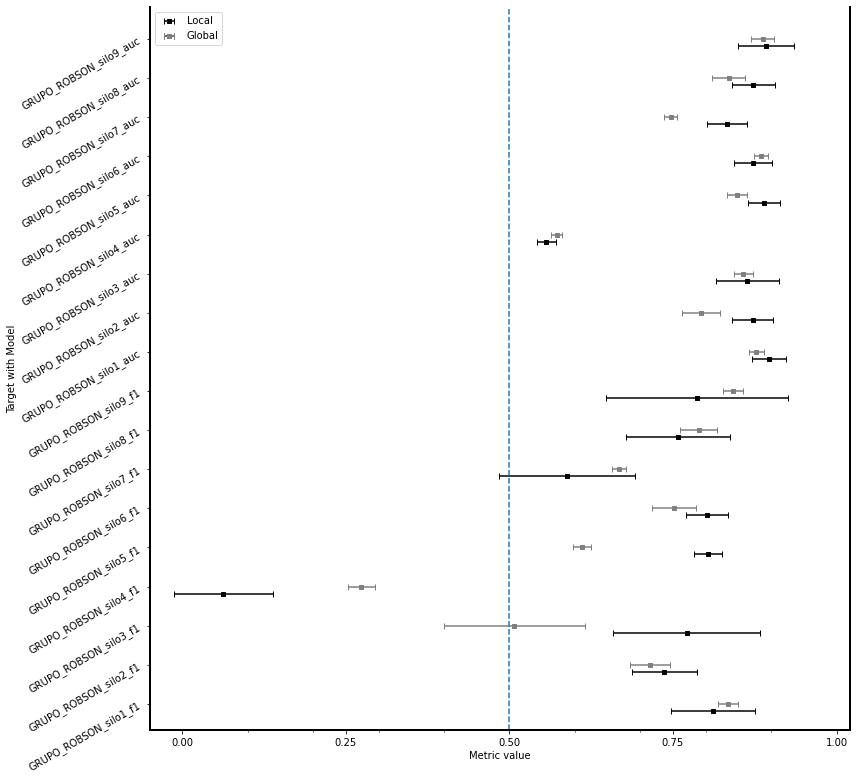

In [63]:
final = get_stats(total)
plot_paper_grade_error(final)

In [64]:
%%time
import warnings

warnings.filterwarnings("ignore")
# decision tree
# CPU times: user 5min 49s, sys: 1min 12s, total: 7min 2s (repeats 2)
# CPU times: user 26min 23s, sys: 7min 31s, total: 33min 55s (repeats 10)
# CPU times: user 14min 19s, sys: 29.6 s, total: 14min 48s Wall time: 15min 23s (repeats 10:cv5)
# voting é o unico justo. stacking com o learn com um X train fica mt bom nesse e mau nos outros
# ensemble ainda n sei bem
total_dt = evalute_full_method(
    targets=[
        "GRUPO_ROBSON",
        "TIPO_GRAVIDEZ",
        "EUTOCITO_ANTERIOR",
        "CESARIANAS_ANTERIOR",
        "CARDIACA",
        "TIPO_PARTO",
        "BACIA",
        "DIABETES_GESTACIONAL",
        "APRESENTACAO_NO_PARTO",
    ],
    metrics=["f1", "roc_auc_score"],
    silos=silo_imputed,
    cv=10,
    tuned_parameters=[
        {"criterion": ["gini", "entropy"], "max_features": ["log2", "auto"]}
    ],
    model=DecisionTreeClassifier(),
    repeats=10,
    model_type="ensemble",
)
alarm

evaluating GRUPO_ROBSON... 
evaluating TIPO_GRAVIDEZ... 
evaluating EUTOCITO_ANTERIOR... 
evaluating CESARIANAS_ANTERIOR... 
evaluating CARDIACA... 
evaluating TIPO_PARTO... 
evaluating BACIA... 
evaluating DIABETES_GESTACIONAL... 
evaluating APRESENTACAO_NO_PARTO... 
CPU times: user 5min 44s, sys: 33.8 s, total: 6min 18s
Wall time: 8min 33s


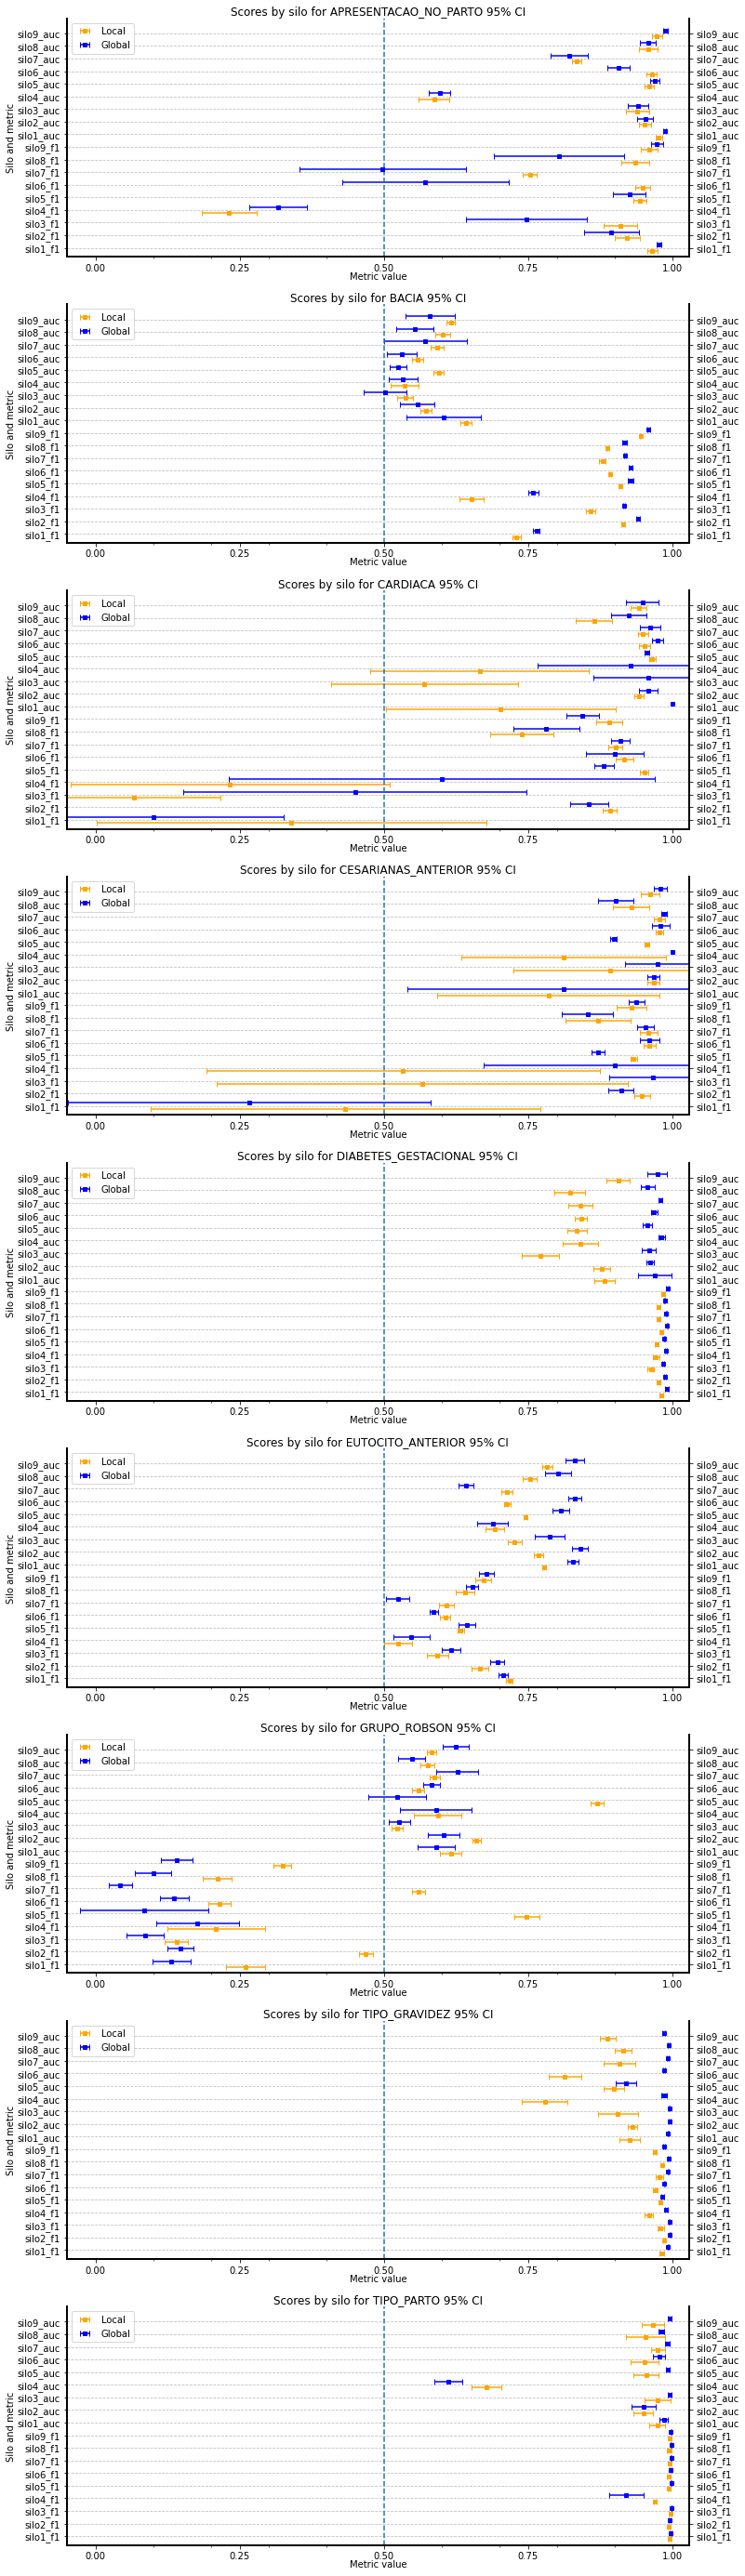

In [66]:
final_dt = get_stats(total_dt)
plot_paper_grade_error(final_dt)

In [67]:
tt = get_ttest(total_dt)
#for k, v in tt.items():
#    print(pd.DataFrame.from_dict(tt[k]))

In [68]:
%%time
total_nb = evalute_full_method(
    targets=[
        "GRUPO_ROBSON",
        "TIPO_GRAVIDEZ",
        "EUTOCITO_ANTERIOR",
        "CESARIANAS_ANTERIOR",
        "CARDIACA",
        "TIPO_PARTO",
        "BACIA",
        "DIABETES_GESTACIONAL",
        "APRESENTACAO_NO_PARTO",
    ],
    metrics=["f1", "roc_auc_score"],
    silos=silo_imputed,
    cv=5,
    tuned_parameters=[{"var_smoothing": [1e-9, 1e-8, 1e-7]}],
    model=GaussianNB(),
    repeats=10,
    model_type="ensemble",
)
alarm

evaluating GRUPO_ROBSON... 
evaluating TIPO_GRAVIDEZ... 
evaluating EUTOCITO_ANTERIOR... 
evaluating CESARIANAS_ANTERIOR... 
evaluating CARDIACA... 
evaluating TIPO_PARTO... 
evaluating BACIA... 
evaluating DIABETES_GESTACIONAL... 
evaluating APRESENTACAO_NO_PARTO... 
CPU times: user 3min 57s, sys: 14 s, total: 4min 11s
Wall time: 5min 8s


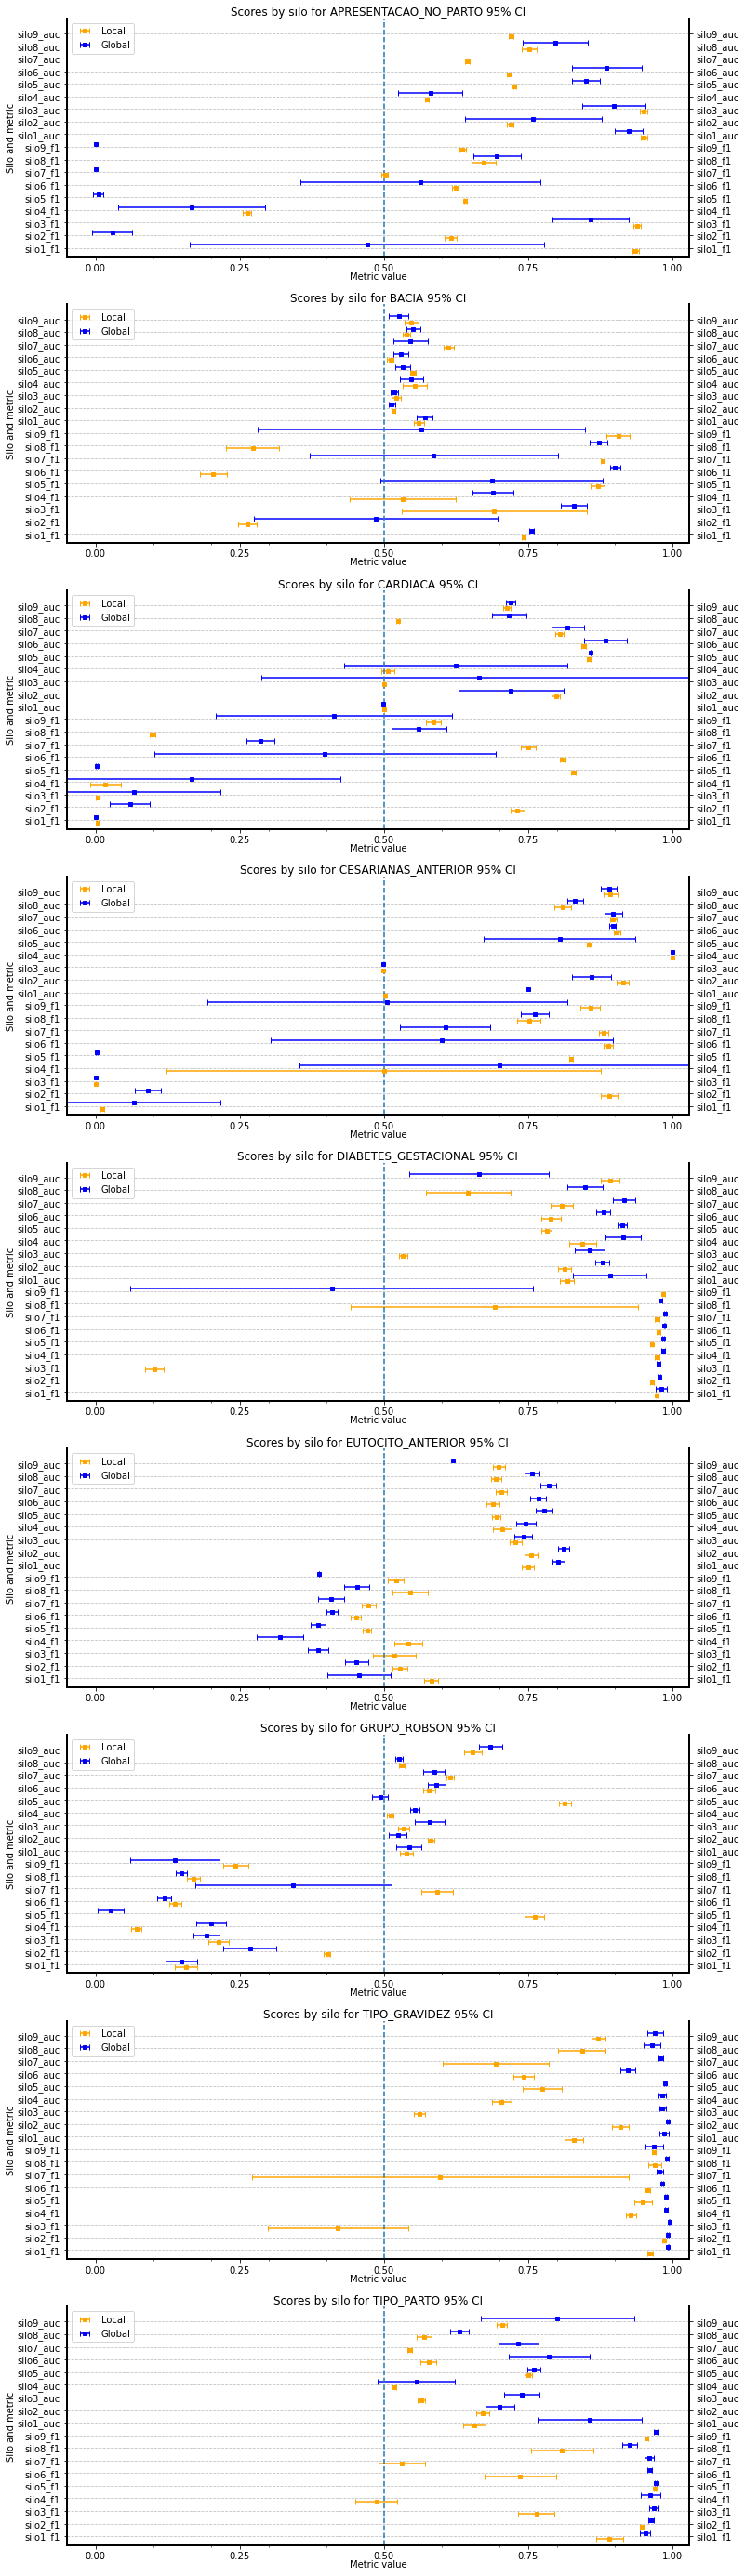

In [69]:
final_nb = get_stats(total_nb)
plot_paper_grade_error(final_nb)

In [46]:
%%time

total_br = evalute_full_method(
    targets=[
        "GRUPO_ROBSON",
        "TIPO_GRAVIDEZ",
        "EUTOCITO_ANTERIOR",
        "CESARIANAS_ANTERIOR",
        "CARDIACA",
        "TIPO_PARTO",
        "BACIA",
        "DIABETES_GESTACIONAL",
        "APRESENTACAO_NO_PARTO",
    ],
    metrics=["f1", "roc_auc_score"],
    silos=silo_imputed,
    cv=5,
    tuned_parameters=[
        {
            "n_iter": [300, 400, 500],
            "lambda_1": [1e-6, 1e-5, 5e-5],
            "lambda_2": [1e-6, 1e-5, 5e-5],
        }
    ],
    model=BayesianRidge(),
    repeats=10,
    model_type="ensemble",
)
alarm

evaluating GRUPO_ROBSON... 


AttributeError: 'BayesianRidge' object has no attribute 'predict_proba'

# Total Model - the best with all data

In [154]:
def prepare_global_model(g_model, X_train, y_train):
    if type(g_model) == StackingClassifier:
        return g_model.fit(X_train, y_train)
    elif type(g_model) == EnsembleVoteClassifier:
        return g_model.fit(X_train, y_train)
    else:
        threshold = get_best_threshold(global_model, [X_train], [y_train])
        g_model.tune_estimator_weights([X_train], [y_train], scoring="roc_auc_score")
        g_model.set_threshold(threshold[0])
        return g_model

In [227]:
def create_total_model_and_evaluate(
    silos,
    targets,
    parameters,
    global_model,
    locals_,
    model=SGDClassifier(loss="log"),
    cv=3,
    nr_repeats=20,
):
    np.random.seed(42)
    minisilos = [silo.sample(1000) for silo in silos]  # keep same nr rows
    full_data = pd.concat(minisilos).reset_index(drop=True)
    full_metric = defaultdict(dict)
    for target in targets:
        full_metric[target] = {
            "total": {"auc": [], "f1": []},
            "global": {"auc": [], "f1": []},
        }
        for i in range(nr_repeats):
            r_s = np.random.randint(1, nr_repeats)
            total_clf = GridSearchCV(
                model.set_params(random_state=r_s),
                param_grid=parameters,
                cv=StratifiedKFold(n_splits=cv),
                n_jobs=-2,
            )
            y = full_data[target]
            X = full_data.drop(columns=[target])
            yy, l = create_target(y, op="binarizer")  # this should be addressed

            X_train, X_test, y_train, y_test = train_test_split(
                X, yy[:, 0], test_size=0.2, stratify=yy[:, 0]
            )
            total_clf.fit(X_train, y_train)
            g_model = prepare_global_model(
                global_model[target]["g_model"][0]["ensemble"], X_train, y_train
            )
            full_metric[target]["total"]["auc"].append(
                roc_auc_score(total_clf.best_estimator_.predict(X_test), y_test)
            )
            full_metric[target]["global"]["auc"].append(
                roc_auc_score(g_model.predict(X_test), y_test)
            )
            full_metric[target]["total"]["f1"].append(
                f1_score(total_clf.best_estimator_.predict(X_test), y_test)
            )
            full_metric[target]["global"]["f1"].append(
                f1_score(g_model.predict(X_test), y_test)
            )
    return full_metric


total_metric = create_total_model_and_evaluate(
    silos=silo_imputed,
    targets=[
        "GRUPO_ROBSON",
        "TIPO_GRAVIDEZ",
        "EUTOCITO_ANTERIOR",
        "CESARIANAS_ANTERIOR",
        "CARDIACA",
        "TIPO_PARTO",
        "BACIA",
        "DIABETES_GESTACIONAL",
        "APRESENTACAO_NO_PARTO",
    ],
    parameters=[{"criterion": ["gini", "entropy"], "max_features": ["log2", "auto"]}],
    global_model=total_dt,
    model=DecisionTreeClassifier(),
    locals_=[model for model in total_dt["GRUPO_ROBSON"]["models"][0]],
)

In [228]:
for k, v in total_metric.items():
    ttest, pval = ttest_ind(v["total"]["auc"], v["global"]["auc"], nan_policy="omit")
    print(k, pval)

GRUPO_ROBSON 0.6391634082885472
TIPO_GRAVIDEZ 9.483650908992013e-05
EUTOCITO_ANTERIOR 1.0604020423966389e-13
CESARIANAS_ANTERIOR 0.053477017932097456
CARDIACA 4.544532353747224e-24
TIPO_PARTO 8.004735515261996e-16
BACIA 1.3111764590192214e-07
DIABETES_GESTACIONAL 3.529436858786538e-17
APRESENTACAO_NO_PARTO 0.3613320226575423


In [71]:
def prepare_data_for_total_viz(total_metric):
    label = []
    total_values = []
    median = []
    dict_values = {}
    for k, v in total_metric.items():
        for j, t in v.items():
            for u, n in t.items():
                label.append(k + "_" + j + "_" + u)
                total_values.append(n)
                median.append(np.median(n))
                dict_values[k + "_" + j + "_" + u] = n
    return label,total_values,median,dict_values
label,total_values,median,dict_values=prepare_data_for_total_viz(total_metric)

NameError: name 'total_metric' is not defined

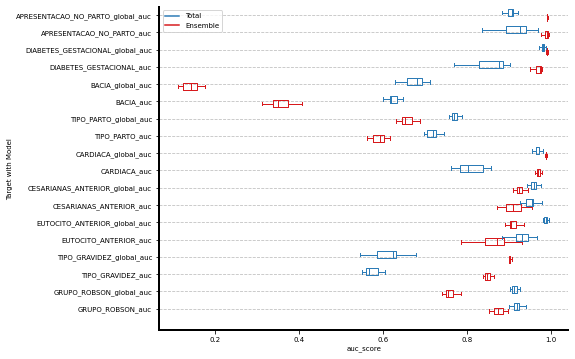

In [231]:
def plot_total_boxplot(total_values):
    def set_box_color(bp, color):
        plt.setp(bp["boxes"], color=color)
        plt.setp(bp["whiskers"], color=color)
        plt.setp(bp["caps"], color=color)
        plt.setp(bp["medians"], color=color)


    plt.rcParams["font.size"] = 7

    fig = plt.figure(figsize=(8, 5))
    data_a = total_values[1::2]
    data_b = total_values[0::2]
    l_label = [x.replace("_total", "") for x in label[0::2]]
    bpl = plt.boxplot(
        data_a,
        positions=np.array(range(len(data_a))) * 1.5 + 0.4,
        vert=False,
        sym="",
        widths=0.6,
        manage_ticks=False,
    )
    bpr = plt.boxplot(
        data_b,
        positions=np.array(range(len(data_b))) * 1.5 + 0.8,
        vert=False,
        sym="",
        widths=0.6,
        labels=l_label,
    )
    set_box_color(bpl, "#D7191C")  # colors are from http://colorbrewer2.org/
    set_box_color(bpr, "#2C7BB6")
    ax = plt.axes()
    # plt.title('Scores by target and model')
    ax.set_ylabel("Target with Model", labelpad=3)
    ax.set_xlabel("auc_score", labelpad=3)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c="#2C7BB6", label="Total")
    plt.plot([], c="#D7191C", label="Ensemble")
    plt.legend()
    ax.set_yticks(np.array(range(len(data_a))) * 1.5 + 0.6)
    ax.yaxis.grid(True, which="major", linestyle="--", color="gray", alpha=0.5)
    plt.tight_layout()
    plt.savefig("Total_compare.png")  
    

In [238]:
def plot_error_total(dict_values):
    data_total = [v for k, v in dict_values.items() if "total" in k]
    data_ensemble = [v for k, v in dict_values.items() if "global" in k]
    l_label = [k.replace("_total", "") for k, v in dict_values.items() if "total" in k]
    fig = plt.figure(figsize=(10, 15))
    plt.rcParams["font.size"] = 10

    y_1 = np.linspace(0, 20, len(l_label))
    ci_a = [
        st.t.interval(
            alpha=0.95,
            df=len(t) - 1,
            loc=np.nanmean(t),
            scale=st.sem(t, nan_policy="omit"),
        )
        for t in data_total
    ]

    m_a = [np.mean(t) for t in data_total]
    ci_1a = np.subtract(np.array(m_a), np.array([c[0] for c in ci_a]))

    ci_b = [
        st.t.interval(
            alpha=0.95,
            df=len(t) - 1,
            loc=np.nanmean(t),
            scale=st.sem(t, nan_policy="omit"),
        )
        for t in data_ensemble
    ]

    m_b = [np.mean(t) for t in data_ensemble]
    ci_1b = np.subtract(np.array(m_b), np.array([c[0] for c in ci_b]))

    b1 = plt.errorbar(
        x=m_a,
        y=y_1,
        xerr=ci_1a,
        color="green",
        capsize=5,
        linestyle="None",
        marker="s",
        markersize=8,
        mfc="green",
        mec="green",
    )
    g1 = plt.errorbar(
        x=m_b,
        y=y_1 - 0.5,
        xerr=ci_1b,
        color="orange",
        capsize=5,
        linestyle="None",
        marker="s",
        markersize=8,
        mfc="orange",
        mec="orange",
    )
    plt.yticks(y_1 - 0.25, l_label)
    plt.grid(True, which="major", linestyle="--", color="gray", alpha=0.5, axis="y")
    plt.legend([b1, (b1, g1)], ["Total", "Ensemble"], loc=2)
    plt.axvline(0.50, ls="--")

    plt.show()

In [256]:
for k, v in total_metric.items():
    print(k, round(np.mean(v["global"]["auc"]) / np.mean(v["total"]["auc"]) * 100, 2,))

GRUPO_ROBSON 99.77
TIPO_GRAVIDEZ 107.36
EUTOCITO_ANTERIOR 106.12
CESARIANAS_ANTERIOR 100.82
CARDIACA 119.7
TIPO_PARTO 107.52
BACIA 107.82
DIABETES_GESTACIONAL 113.81
APRESENTACAO_NO_PARTO 99.01


In [ ]:
# TODO, mais regressao

### run single models to atest speed  -TESTES

In [72]:
X, y, pipe, l = create_pipeline_with_y(
    silos[0], "GRUPO_ROBSON", int_cols, cat_cols, as_df=True, drop_cols=drop_cols
)

52


In [ ]:
%%time
i = 0
p = 0
idddd = []
X = silosprep[1].drop(columns=["BISHOP_DESCIDA_0.0"])
y = silosprep[1]["BISHOP_DESCIDA_0.0"]
grid_list = []
models = []
times = []
for test_model in test_models:
    for j in range(10):
        total_clf = GridSearchCV(
            KNeighborsClassifier(),
            cv=10,
            param_grid=[{"n_neighbors": [5, 3, 7]}],
            n_jobs=-2,
        )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        total_clf.fit(X_train, y_train)
        models.append(total_clf.best_estimator_)
        grid_list.append(total_clf)

In [78]:
XX, yy, pip, l = create_pipeline_with_y(
    silos[0], "GRUPO_ROBSON", int_cols, cat_cols, drop_cols, op="binarizer"
)
XX2, yy2, pip2, l2 = create_pipeline_with_y(
    silos[1], "GRUPO_ROBSON", int_cols, cat_cols, drop_cols, op="binarizer"
)

TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2, stratify=yy)

In [ ]:
tt = GridSearchCV(
    OneVsRestClassifier(SGDClassifier(random_state=42)),
    cv=10,
    param_grid=[{"estimator__alpha": [0.0001, 0.01], "estimator__l1_ratio": [0.05]}],
    n_jobs=-2,
    scoring=["accuracy"],
    refit="accuracy",
)
pp = tt.fit(X_train, y_train)

In [ ]:
pp.best_estimator_

In [77]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    XX2, yy2, test_size=0.2, stratify=yy2
)
tt2 = GridSearchCV(
    OneVsRestClassifier(SGDClassifier(random_state=42)),
    cv=10,
    param_grid=[{"estimator__alpha": [0.0001, 0.01], "estimator__l1_ratio": [0.05]}],
    n_jobs=-2,
    scoring=["accuracy"],
    refit="accuracy",
)
pp2 = tt.fit(X_train2, y_train2)

NameError: name 'XX2' is not defined

In [ ]:
pp2.best_estimator_.partial_fit(X_train, y_train)

In [ ]:
create_auc_score(pp.predict(X_test), y_test, l.classes_)

In [ ]:
accuracy_score(pp.best_estimator_.predict(X_test2), y_test2)

In [ ]:
pp.predict(X_test)

In [ ]:
silos[0]["GRUPO_ROBSON"].unique()

In [ ]:
pd.DataFrame(
    classification_report(
        pp.predict(X_test), y_test, target_names=l.classes_, output_dict=True
    )
)

In [ ]:
accuracy_score(pp.predict(X_test), y_test)

In [ ]:
multilabel_confusion_matrix(pp.predict(X_test), y_test)

In [ ]:
y_pred = pp.predict_proba(X_test)

In [ ]:
y_pred_ = pp.predict(X_test)

In [ ]:
y_pred_[:, 0]

In [ ]:
def create_auc_score(y_true, y_test, classes):
    final_result = {}
    for idx, class_ in enumerate(classes):
        try:
            final_result[class_] = roc_auc_score(y_pred_[:, idx], y_test[:, idx])
        except:
            final_result[class_] = np.nan

    return final_result

In [ ]:
create_auc_score(y_pred_, y_test, l.classes_)

In [ ]:
xx, yy, pipe, l = create_pipeline_with_y(
    silos[0],
    "GRUPO_ROBSON",
    int_cols,
    cat_cols,
    as_df=False,
    drop_cols=drop_cols,
    op="binarizer",
)

In [ ]:
y = silo_imputed[0]["GRUPO_ROBSON"]
X = silo_imputed[0].drop(columns=["GRUPO_ROBSON"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy[:, 0], test_size=0.2, stratify=yy[:, 0]
)

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
tt = GridSearchCV(
    clf,
    cv=10,
    param_grid=[{"criterion": ["gini", "entropy"], "max_features": ["log2", "auto"],}],
    n_jobs=-2,
    scoring=["accuracy"],
    refit="accuracy",
)
pp = tt.fit(X_train, y_train)

In [ ]:
y_pred = pp.best_estimator_.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
y_pred = pp.best_estimator_.predict(X_test)
multilabel_confusion_matrix(y_test, y_pred)

In [ ]:
roc_auc_score(y_true=y_test,y_score=,multi_class="ovr")

In [ ]:
plot_confusion_matrix(pp.best_estimator_, X_test, y_test);

### MClasse

In [73]:
y = silo_imputed[0]["GRUPO_ROBSON"]
X = silo_imputed[0].drop(columns=["GRUPO_ROBSON"])
yy, l = create_target(y, op="binarizer")

X_train, X_test, y_train, y_test = train_test_split(
    X, yy[:, 0], test_size=0.2, stratify=yy[:, 0]
)
sclf.fit(X_train, y_train)

NameError: name 'sclf' is not defined

In [ ]:
sclf.decision_function(X_test)

In [ ]:
accuracy_score(sclf.predict(X_test), y_test)

In [ ]:
accuracy_score(total_dt["GRUPO_ROBSON"]["g_model"][0][0][0].predict(X_test), y_test)

In [164]:
df=silo_imputed[0].copy()
s=df.GRUPO_ROBSON.value_counts().gt(4)
df=df.loc[df.GRUPO_ROBSON.isin(s[s].index)]

y = df["GRUPO_ROBSON"]
X = df.drop(columns=["GRUPO_ROBSON"])
yy, l = create_target(y, op="binarizer")

X_train, X_test, y_train, y_test = train_test_split(
    X, yy, test_size=0.2, stratify=yy
)
tree=DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [165]:
y_pred=tree.predict(X_test)
y_pred_proba=tree.predict_proba(X_test)

In [168]:
roc_auc_score(y_true=y_test,y_score=y_pred,average="weighted")

0.987784427497708

In [167]:
f1_score(y_test,y_pred,average="weighted")

0.9782956882995434

In [108]:
y_pred_proba

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [163]:
np.count_nonzero(y_pred,axis=0)

array([361, 174, 235, 292, 154, 160,  82,  47,   0,   1, 102])

In [153]:
df
counts=silo_imputed[0]["GRUPO_ROBSON"].value_counts()
threshold = 4 # Anything that occurs less than this will be removed.

to_remove = counts[counts <= threshold].index
silo_imputed[0]["GRUPO_ROBSON"].replace(to_remove, np.nan)


0       1.0
1       1.0
2       3.0
3       3.0
4       3.0
       ... 
8034    2.0
8035    5.0
8036    4.0
8037    0.0
8038    3.0
Name: GRUPO_ROBSON, Length: 8039, dtype: float64

,IDADE_MATERNA,PESO_INICIAL,IMC,NUMERO_CONSULTAS_PRE_NATAL,IDADE_GESTACIONAL_ADMISSAO,SEMANAS_GESTACAO_PARTO,PESO_ADMISSAO_INTERNAMENTO,ESTUPEFACIENTES,DIABETES_TIPO2,GS,...,BISHOP_DESCIDA,A_GESTA,RPM,BACIA,DIABETES_GESTACIONAL_DIETA,A_PARA,TIPO_GRAVIDEZ,DIABETES_GESTACIONAL_INSULINA,HIPERTENSAO_GESTACIONAL,GRUPO_ROBSON
0,34.0,62.0,27.9,7.0,27.0,28.0,79.0,1.0,1.0,7.0,...,4.0,3.0,1.0,3.0,1.0,1.0,6.0,1.0,1.0,1
1,34.0,62.0,27.9,7.0,27.0,28.0,79.0,1.0,1.0,7.0,...,4.0,3.0,1.0,3.0,1.0,1.0,6.0,1.0,1.0,1
2,24.0,52.0,22.8,3.0,38.0,38.0,79.0,1.0,1.0,8.0,...,4.0,4.0,1.0,3.0,0.0,2.0,0.0,1.0,1.0,3
3,24.0,52.0,22.8,3.0,38.0,38.0,79.0,1.0,1.0,8.0,...,4.0,4.0,1.0,3.0,0.0,2.0,0.0,1.0,1.0,3
4,36.0,65.0,24.7,10.0,37.0,37.0,79.0,1.0,1.0,5.0,...,4.0,5.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8034,28.0,56.0,21.9,9.0,40.0,41.0,79.0,1.0,1.0,1.0,...,4.0,3.0,1.0,3.0,1.0,9.0,0.0,1.0,1.0,2
8035,38.0,78.0,27.0,4.0,40.0,40.0,79.0,1.0,1.0,1.0,...,4.0,5.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,5
8036,30.0,76.0,30.4,6.0,40.0,41.0,79.0,1.0,1.0,0.0,...,4.0,4.0,1.0,3.0,1.0,1.0,6.0,1.0,1.0,4
8037,26.0,90.0,31.5,9.0,39.0,39.0,79.0,1.0,1.0,5.0,...,4.0,0.0,1.0,3.0,1.0,9.0,0.0,1.0,1.0,0


In [ ]:


    to_remove = value_counts[value_counts <= threshold].index
    df[col].replace(to_remove, np.nan, inplace=True)

In [114]:
y = silo_imputed[0]["GRUPO_ROBSON"]
X = silo_imputed[0].drop(columns=["GRUPO_ROBSON"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)
tree=DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [115]:
y_pred=tree.predict(X_test)
y_pred_proba=tree.predict_proba(X_test)

In [116]:
y_pred

array([ 0,  1, 10, ...,  2,  2,  0])

In [122]:
roc_auc_score(y_true=y_test,y_score=y_pred_proba,multi_class="ovr")

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [123]:
y_test.unique()

array([ 0,  1, 10,  5,  7,  6,  3,  4,  2,  9])

In [125]:
y_pred_proba[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [130]:
y.value_counts()

0     1800
3     1483
2     1166
1      859
4      787
5      767
10     537
6      402
7      233
9        3
8        2
Name: GRUPO_ROBSON, dtype: int64

In [131]:
y_test.value_counts()

0     360
3     297
2     233
1     172
4     158
5     153
10    107
6      80
7      47
9       1
Name: GRUPO_ROBSON, dtype: int64

In [132]:
y_train.value_counts()

0     1440
3     1186
2      933
1      687
4      629
5      614
10     430
6      322
7      186
9        2
8        2
Name: GRUPO_ROBSON, dtype: int64

In [133]:
#remove low frequency like less than 3

In [ ]:
def

In [138]:
a=np.count_nonzero(y_test,axis=0)

In [139]:
b = np.where(a)


In [142]:
c=np.zeros((5,5))

In [140]:
b

(array([8, 9]),)

In [ ]:
np.delete(y_test, 1, 0)

In [144]:
np.delete(c,1,0)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [145]:
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])

In [148]:
np.delete(arr,3,1)

array([[ 1,  2,  3],
       [ 5,  6,  7],
       [ 9, 10, 11]])

In [146]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])